  Activating project at `~/Desktop/Research/FinalVersions/new_environment_name`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Research/FinalVersions/new_environment_name/Project.toml`
  No Changes to `~/Desktop/Research/FinalVersions/new_environment_name/Manifest.toml`


Precompiling project...


  ✓ Scratch
  ✓ Adapt


  ✓ Compat


  ✓ OrderedCollections


  ✓ GPUArraysCore


  ✓ ContextVariablesX


  ✓ IRTools


  ✓ ChainRulesCore


  ✓ Tables


  ✓ FLoopsBase


  ✓ DataStructures


  ✓ ZygoteRules


  ✓ AbstractFFTs


  ✓ LogExpFunctions


  ✓ Optimisers


  ✓ StructArrays


  ✓ SortingAlgorithms


  ✓ BangBang


  ✓ StaticArrays


  ✓ GPUArrays


  ✓ StatsBase


  ✓ MicroCollections


  ✓ SpecialFunctions


  ✓ DiffRules


  ✓ GPUCompiler


  ✓ Transducers


  ✓ ChainRules


  ✓ KernelAbstractions


  ✓ ForwardDiff


  ✓ FLoops


  ✓ NNlib


  ✓ OneHotArrays


  ✓ MLUtils


  ✓ Zygote


  ✓ CUDA


  ✓ cuDNN


  ✓ NNlibCUDA


  ✓ Flux
  38 dependencies successfully precompiled in 163 seconds. 62 already precompiled.


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 64, tanh)
│   summary(x) = 2-element Vector{Float64}
└ @ Flux /Users/faezehbahadorirad/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


Error between the prediction and the reference solution: 0.002185513250419627


┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:43


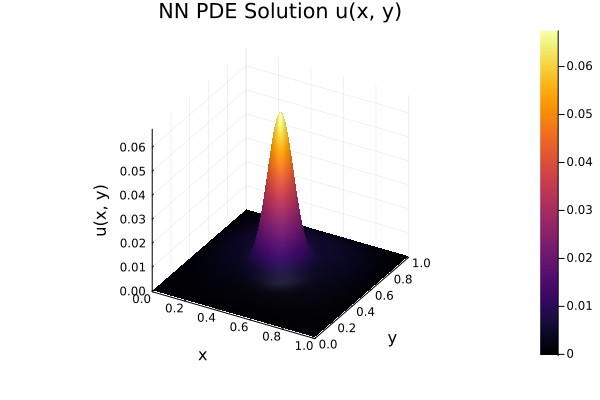

In [1]:
using Pkg
Pkg.activate("new_environment_name")  # Create a new environment
Pkg.add("Flux") # and add all the required packages to this environment.

using Flux, Optim
using Flux: params, train!
using Zygote: gradient
using Random
import QuasiMonteCarlo
using Statistics

# Neural network
nn = Chain(Dense(2, 64, tanh), Dense(64, 1))

al = 100

# Trial function with boundary conditions
function u(x, y, nn)
    f = exp(-al * ((x - 0.5)^2 + (y - 0.5)^2))
    return (1 - x) * x * (1 - y) * y * (nn([x, y])[1] + f)
end



#sampler = QuasiMonteCarlo.LatinHypercubeSample()
#dataset1 = QuasiMonteCarlo.sample(500, [0.0,0.0],[1.0,1.0], sampler)

function loss(x, y, nn)
    u_pred = u(x, y, nn)
    h = 1e-5
    u_xx = (u(x + h, y, nn) - 2 * u_pred + u(x - h, y, nn)) / h^2
    u_yy = (u(x, y + h, nn) - 2 * u_pred + u(x, y - h, nn)) / h^2
    Δu = u_xx .+ u_yy
    f = exp(-al * ((x - 0.5)^2 + (y - 0.5)^2))
    return (Δu - f)^2
end

=#
# Compute gradients of the loss function with respect to the network parameters
function loss_gradients(x, y, nn, ps)
    l = loss(x, y, nn)
    return gradient(() -> l, ps)
end
batch_size = 1000
function train_pde_solver(nn, epochs, batch_size)
    opt = ADAM(0.01)
    ps = params(nn)

    for epoch in 1:epochs
        batch_x = rand(batch_size)
        batch_y = rand(batch_size)
        grads = loss_gradients.(batch_x, batch_y, Ref(nn), Ref(ps))
        agg_grads = sum(grads)

        Flux.Optimise.update!(opt, ps, agg_grads)
        
        if epoch % 100 == 0
            println("Epoch: $epoch, Loss: $(loss(rand(), rand(), nn))")
        end
    end
end


function calculate_error(u, nn, reference_solution, resolution=100)
    x_range = range(0, 1, length=resolution)
    y_range = range(0, 1, length=resolution)

    errors = [abs(u(x, y, nn) - reference_solution(x, y)) for x in x_range, y in y_range]
    
    return mean(errors)
end

function reference_solution(x, y)
    return exp(-al*((x-0.5)^2 + (y-0.5)^2))*(x^2-x)*(y^2-y)
end

error = calculate_error(u, nn, reference_solution)
println("Error between the prediction and the reference solution: $error")

using Plots

function plot_solution_3d(u, nn, resolution=1000)
    x_range = range(0, 1, length=resolution)
    y_range = range(0, 1, length=resolution)


    # Calculate u(x, y) values on the grid
    u_values = [u(x, y, nn) for x in x_range, y in y_range] 
    # Create a 3D surface plot of the solution
    surface(x_range, y_range, u_values, xlabel="x", ylabel="y", zlabel="u(x, y)", title="NN PDE Solution u(x, y)")

end
x_range = range(0, 1, length=100)
y_range = range(0, 1, length=100)
u_true = [reference_solution(x, y) for x in x_range, y in y_range]

plot_solution_3d(u, nn)
#fig = surface(x_range, y_range, u(x,y,nn), xlabel="x", ylabel="y", zlabel="u(x, y)", title="True PDE Solution u(x, y)")
